In [1]:
from astropy.io import fits
from astropy.table import Table
from numpy import *
from scipy.interpolate import interp2d
import emcee
import corner
import matplotlib.pyplot as plt
from roman import toRoman
from io import StringIO
import sys
import pickle
import warnings

warnings.filterwarnings("ignore")
plt.style.use('../Python/my_style.mpl')

In [1]:
from math import log10


nH=-4.42
NHi=14.20
NHii=2.52967e+18
T=2.3089e+04

NH=NHii+(10**NHi)

l=(NH/10**nH)*(3.24e-22)   #kpc

P=(10**nH)*T

print(f'NH = {log10(NH):.3f}  L = {l:.3f}  T = {log10(T):.3f}  P = {P:.3f} ')

NH = 18.403  L = 21.559  T = 4.363  P = 0.878 


'Likelihood'

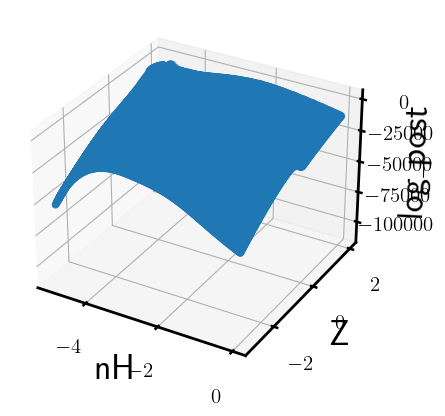

In [2]:
hdu=fits.open(f'Data/component_III_nH_Z_col_density_param.fits')
data=Table(hdu[1].data)


log_nH=data['log_nH']
log_Z=data['log_Z']

lognH_range=[-5,0]
logZ_range=[-3,2]

param=data['parameters']
ions=['Si+2', 'Si+','C+2', 'C+','O+5']

observations={'Si+2':[12.87,0.08],'Si+':[13.19,0.41], 'C+2':[13.81,0.04],'C+':[14.21,0.39], 'O+5':[13.91,0.04]}


interp_func_dict={}

for i in observations.keys():

    with open(f'Interp_2d_func/{i}_quintic.pkl','rb') as pickle_file:
        f=pickle.load(pickle_file)

    interp_func_dict[i]=f



def log_posterior(theta,ions_to_use=['Si+2', 'Si+','C+2', 'C+']):

    lognH,logZ=theta
    
    #prior

    if lognH_range[0]<=lognH<=lognH_range[1] and logZ_range[0]<=logZ<=logZ_range[1]:
         log_prior=0
    
    else:
        log_prior=-inf

    #likelihood
    
    model_col_den=[]
    observed_col_den=[]
    col_den_error=[]

    for i in ions_to_use:

        f=interp_func_dict[i]
        col_den=f(lognH,logZ)
        model_col_den.append(col_den)

        observed_col_den.append(observations[i][0])
        col_den_error.append(observations[i][1])
    
    model_col_den=array(model_col_den)    
    observed_col_den=array(observed_col_den)
    col_den_error=array(col_den_error)

    log_likelihood=-0.5*sum(log(2*pi*(col_den_error**2))+(((observed_col_den-model_col_den)/(col_den_error))**2))

    return log_prior+log_likelihood    # posterior


nH=arange(-5,0,0.02)
Z=arange(-3,2,0.02)

x=zeros(len(nH)*len(Z))
y=zeros(len(nH)*len(Z))
log_post=zeros(len(nH)*len(Z))

k=0
for i,n in enumerate(nH):
    for j,z in enumerate(Z):
        x[k]=n
        y[k]=z
        log_post[k]=log_posterior([n,z])
        k+=1


fig=plt.figure()
ax=plt.axes(projection ='3d')

ax.scatter(x,y,log_post)
ax.set_xlabel('nH')
ax.set_ylabel('Z')
ax.set_zlabel('log_post')

plt.show()
